In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import itertools
import warnings
import matplotlib.ticker as ticker
from arch import arch_model
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.linear_model import LinearRegression





## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 4.1</span>
Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [2]:
# Прочитаем данные, сократим название признака, 
# сделаем значения признака year индексным
data = pd.read_csv('data/ghana_gdp.csv', 
                   parse_dates=["year"],
                   names = ['year','gdp'],
                   skiprows = 1)
data.year = pd.to_datetime(data.year).dt.year
data.set_index('year', inplace=True)
data.head(5)


,gdp
year,
1960,1.217087e+09
1961,0.000000e+00
1962,1.382353e+09
1963,1.540616e+09
1964,1.731092e+09


In [3]:
# Функция для форматирования меток оси Y
def billions(x, pos):
    'Функция для форматирования меток оси Y в миллионах'
    return f'{x / 1e9:.0f} млрд.'
# создадим форматтер
formatter = FuncFormatter(billions)



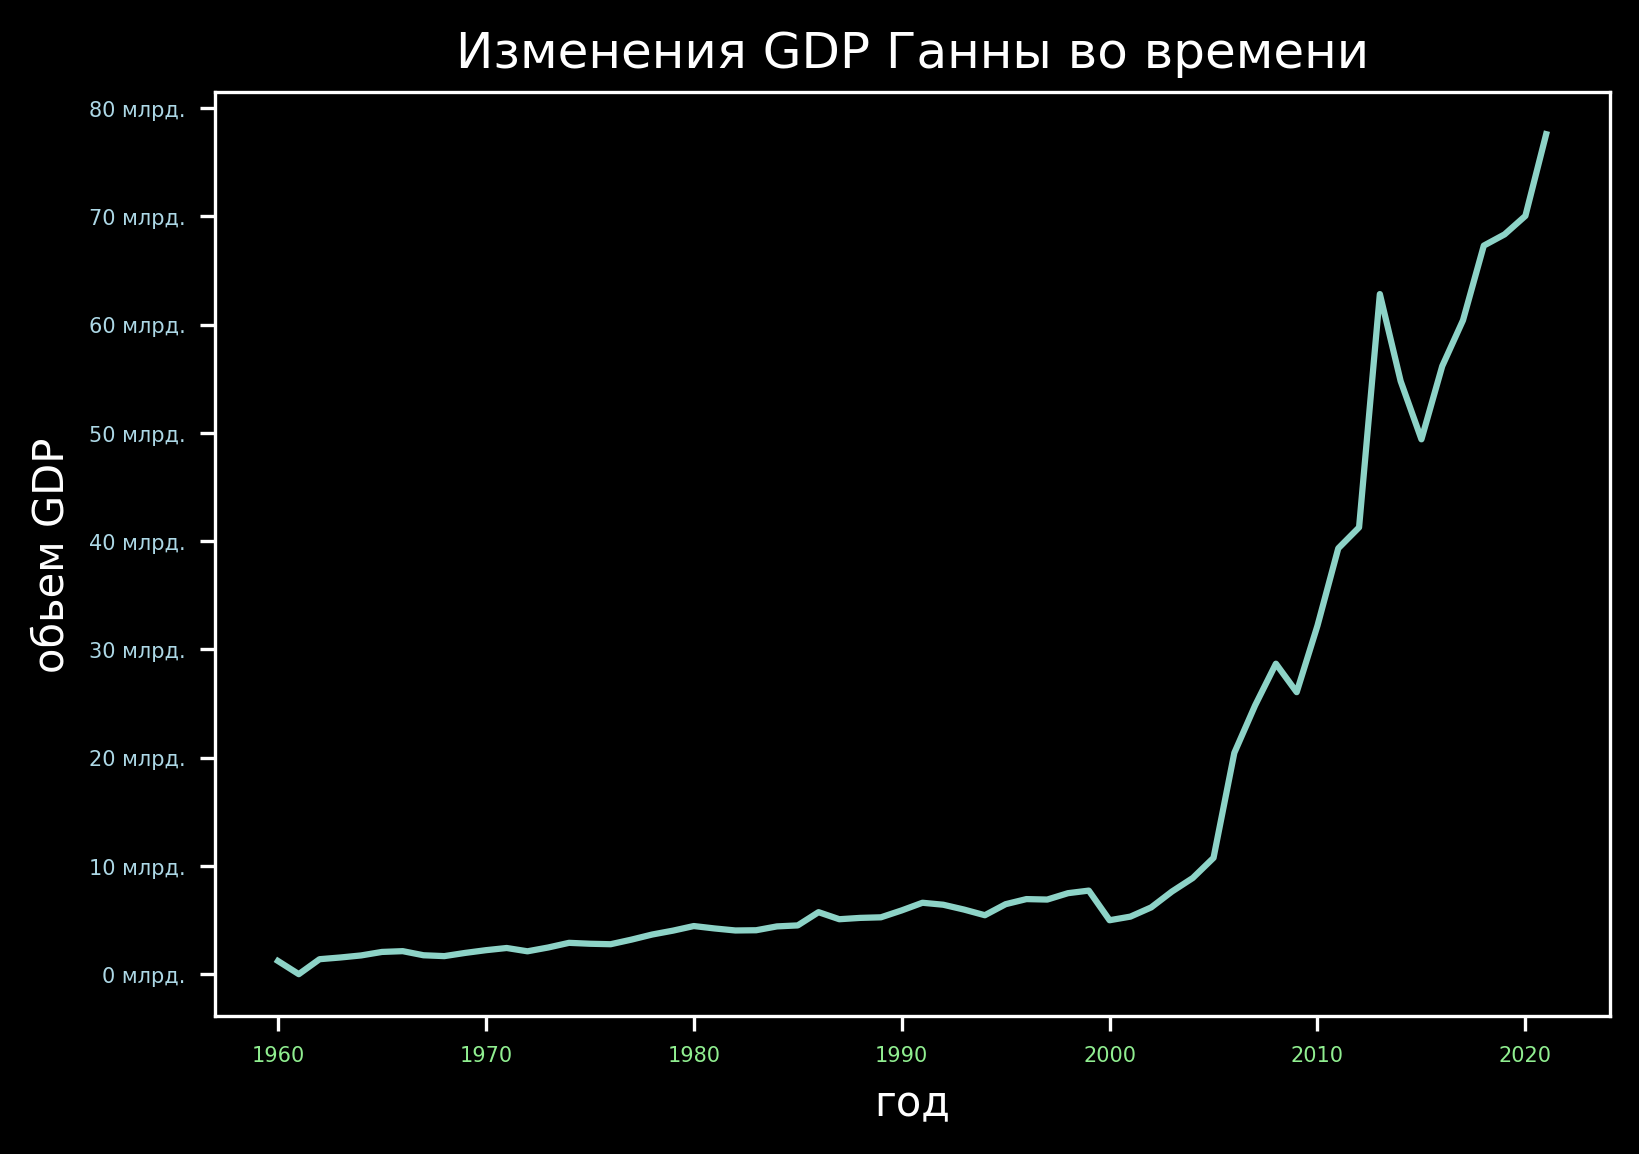

In [4]:
# Отобразим график изменения GDP Ганны за период времени, 
# в указанном датасете

plt.figure(dpi=300, figsize = [6,4])
sns.lineplot(x=data.index, y=data.gdp);

plt.xticks(data.index[::10], fontsize = 5, color = 'lightgreen')
plt.yticks(fontsize = 5, color = 'lightblue')
plt.xlabel('год')
plt.ylabel('обьем GDP')
plt.title('Изменения GDP Ганны во времени')

# Примените форматтер к оси Y

plt.gca().yaxis.set_major_formatter(formatter)

plt.show();


Глядя на данный график можно твердо предположить, что у нас есть чекто выраженный тренд, но отсутствует какая-либо цикличность или сезонность. Чтобы больше убедится или опровергнуть наши догадки, сделаем декомпозицию ряда

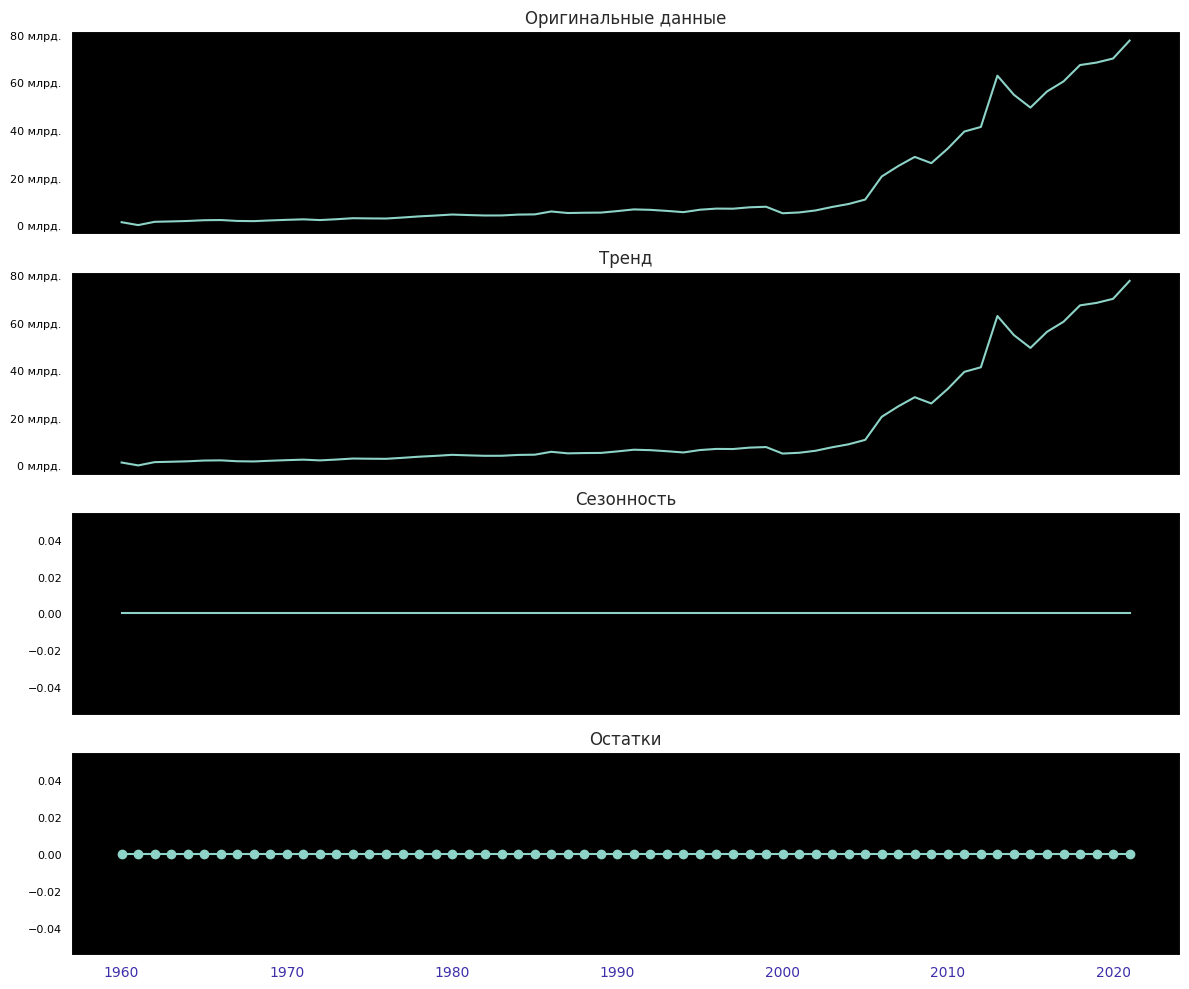

In [5]:
# вернем datatype тип для значения года в индексе, для корректной работы
# seasonal_decompose
data.index = pd.to_datetime(data.index, format='%Y')


# получим декомпозицию ряда
result = seasonal_decompose(data.gdp)
# изначальный график
observed = result._observed
# Получаем компоненту тренда
trend = result.trend
# Получаем компоненту сезонности
seasonal = result.seasonal
# Получаем компоненту остатков
residual = result.resid

# Отобразим каждую компоненту
plt.figure(figsize=(12, 10), facecolor='white')

plt.subplot(411)
plt.plot(observed)
plt.title('Оригинальные данные',fontsize = 12, color = '#292929')
plt.xticks([])
plt.yticks(fontsize = 8, color = 'black')
# форматтер к оси Y
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(412)
plt.plot(trend)
plt.title('Тренд',fontsize = 12, color = '#292929')
plt.xticks([])
plt.yticks(fontsize = 8, color = 'black')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(413)
plt.plot(seasonal)
plt.title('Сезонность',fontsize = 12, color = '#292929')
plt.xticks([])
plt.yticks(fontsize = 8, color = 'black')

plt.subplot(414)
plt.plot(residual, marker = 'o')
plt.title('Остатки',fontsize = 12, color = '#292929')
plt.yticks(fontsize = 8, color = 'black')
plt.xticks(fontsize = 10, color = '#3d2ea9')

plt.tight_layout()
plt.show()



Как мы видим, после разложения временного ряда на тренд, сезонность и остатки, сезонность и остатки, можно сказать, полностью отсутствуют. Есть только наличие тренда.

In [6]:
# Отложим последние три года из датасета, как тестовую выборку для оценки результатов предсказания.
test_df = data.iloc[-3:]
train_df = data.iloc[:-3]

# явно укажем частоту временного ряда, как год, чтобы избежать warning при обучению модели и дать модели, 
# какой у нас используется период точно
train_df.index = pd.to_datetime(train_df.index,format='%Y-%m-%d').to_period(freq='Y')


test_df


,gdp
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 4.2</span>


Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

In [7]:
def rolling_plot(plt: plt, count: int, row : int, window: int = 1) -> None:
    """Функция отвечает за построение графиков скользящего среднего для заданного окна и кол-ва графиков,
    которые располагаются вертикально, один за одним

    Args:
        plt (plt): matplotlib.pyplot обьект
        count (int): кол-во графиков, котрые поместим в обьект pyplot вертикально
        row (int): порядковый номер графика
        window (int, optional): размер окна для функции сглаживания. Defaults to 1.
    """
    plt.subplot(int(str(count)+'1'+str(row)))
    plt.plot(data.gdp, color="blue", label='Оригинальный датасет')
    plt.plot(
        data.gdp.rolling(window=window).mean(),
        color="orange",
        label=f"среднее скользящее при окне = {window}",
    )                
    plt.title(f"среднее скользящее при окне = {window}", fontsize = 12, color = '#292929')
    plt.legend()

    plt.yticks(fontsize = 6, color = 'black')
    plt.gca().yaxis.set_major_formatter(formatter)



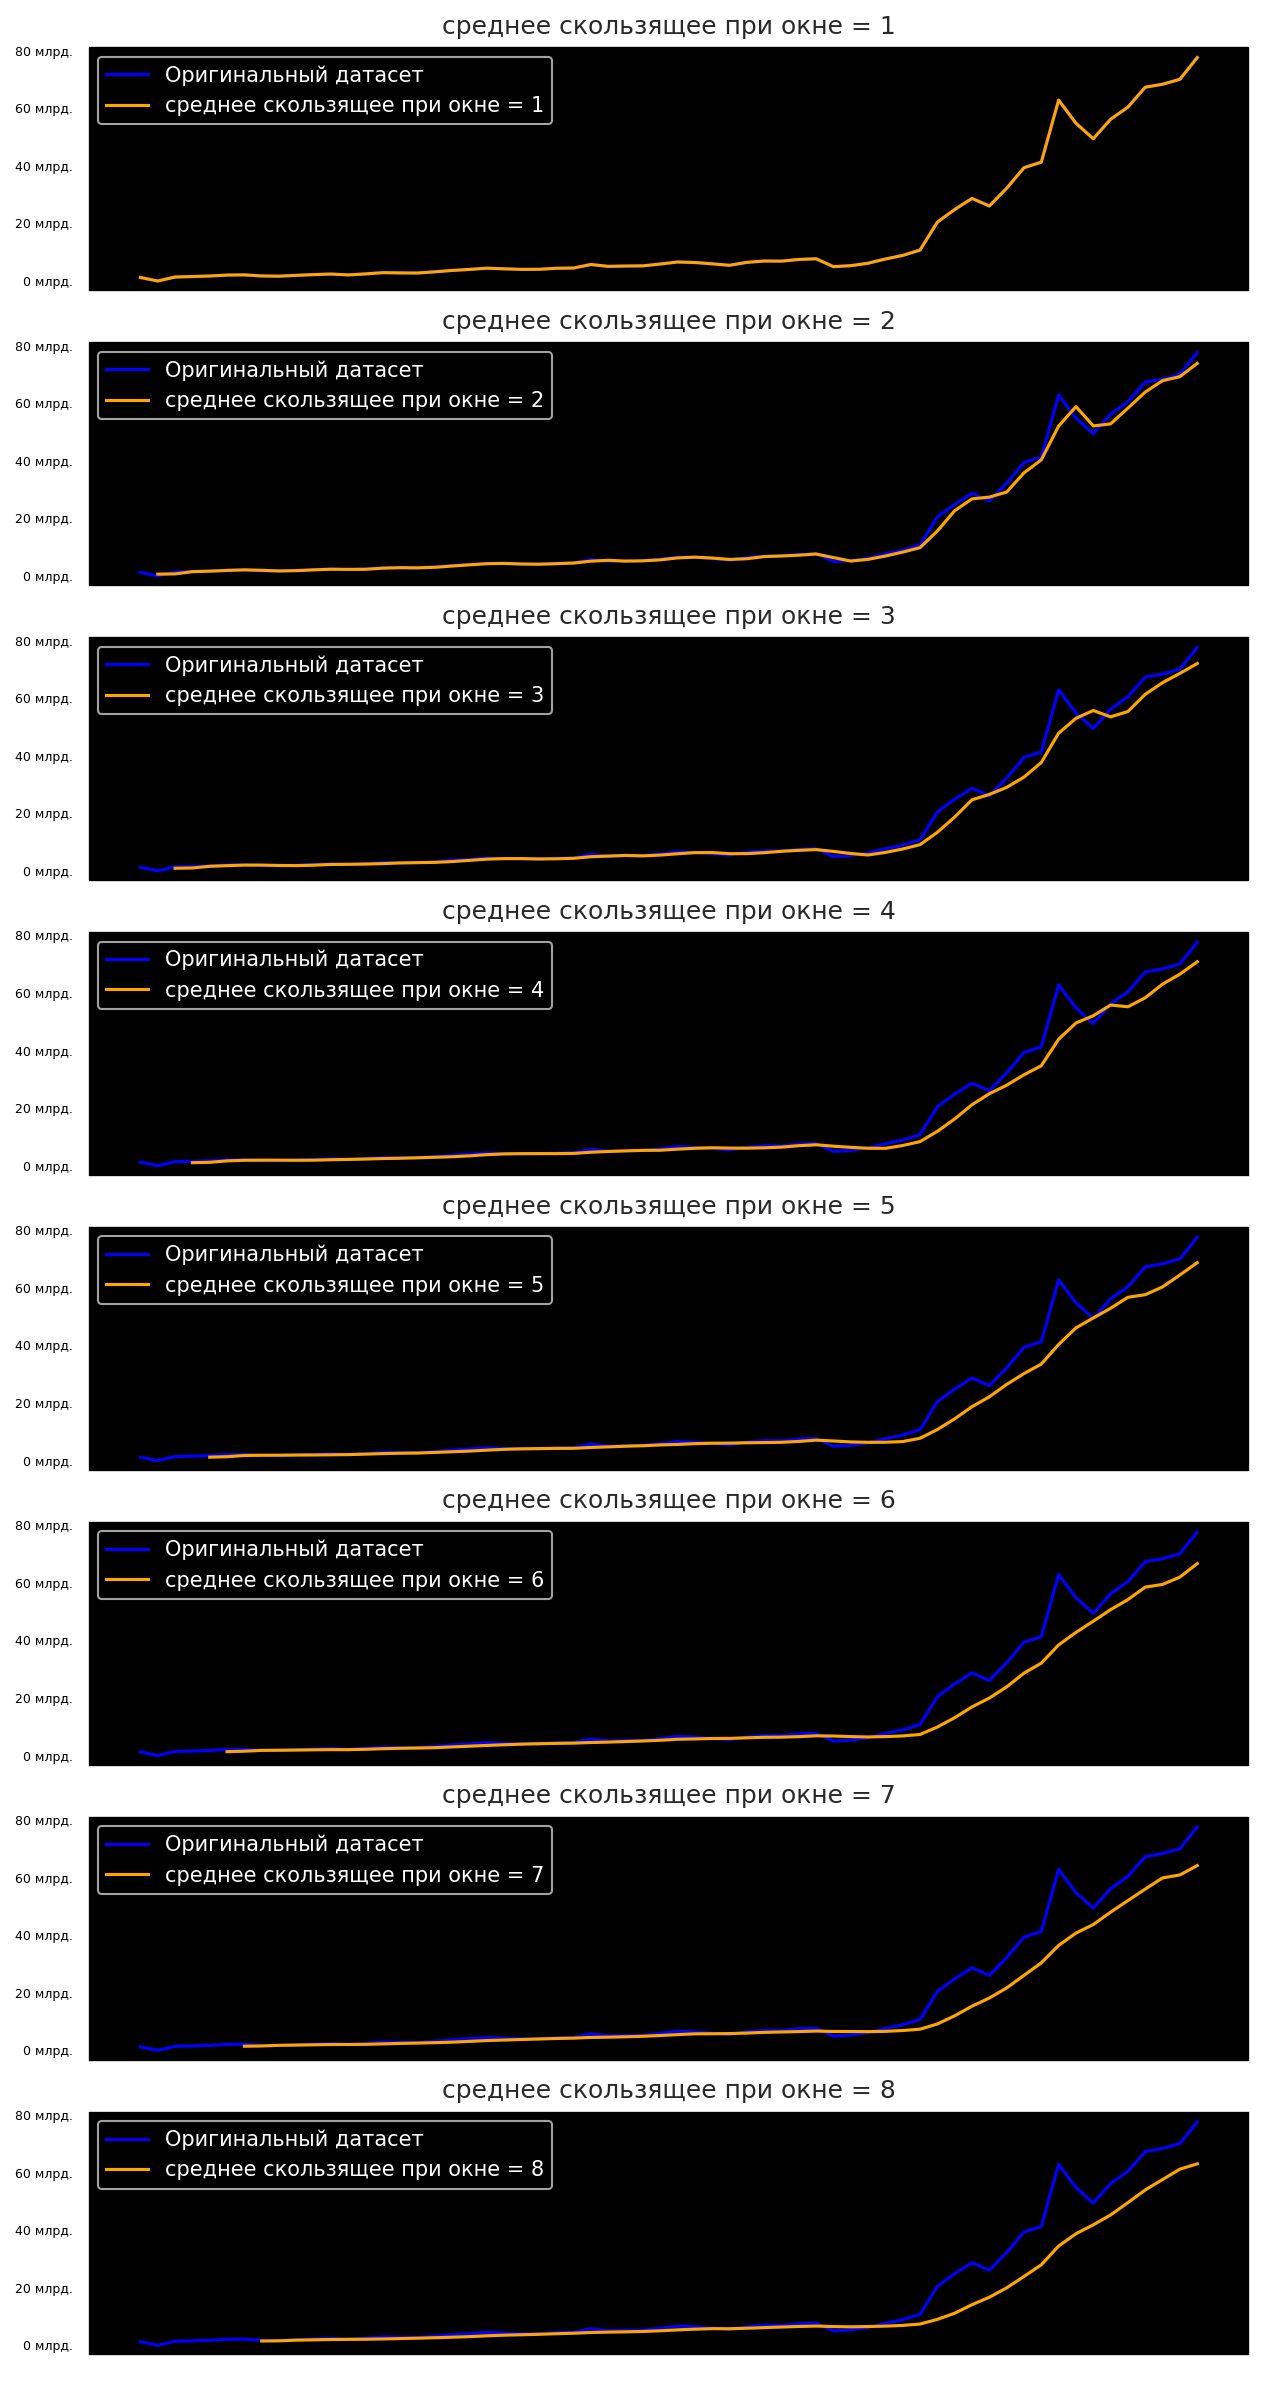

In [8]:
# зададим желаемое кол-во графиков
count = 8
# scale для вертикального размера обьекта plt
y_size = 5
plt.figure(figsize=(10, 4 * y_size), facecolor='white', dpi = 150)

for _ in range(1,count + 1):
    rolling_plot(plt, count,_,_)
plt.show()

В моем понимании, так как изменение GDP Ганны не имеет циклических и сезонных колебаний, а также, мы не рассматриваем влияние каких-либо дополнительных признаков на GDP, то среднее скользящее для последующего упрощенного прогнозирования, лучше выбрать равное 5. Так как при данной величине, линий тренда становится без видимых скачков (это отлично просматривается из графиков выше), что даст в среднем более лучшее прогнозирование. Однако данный метод прогнозирования является очень упрощенным и ожидать от него хороших результатов не стоит.


In [9]:
def predict_ma(data: pd.DataFrame, window: int, predict_count:int) -> list:
    """Функция для предсказания методом MA

    Args:
        data (pd.DataFrame): train датасет
        window (int): размер окна
        predict_count (int): кол-во последовательных случаев, 
        которые надо предсказать на временной шкале

    Returns:
        list: список с предсказанными значениями
    """
    window_for_prediction = data.rolling(window=window).mean().values[-window:]
    
    for _ in range(predict_count):
        window_for_prediction = np.append(window_for_prediction, window_for_prediction[-window:].mean())
    return window_for_prediction[-predict_count:].tolist()

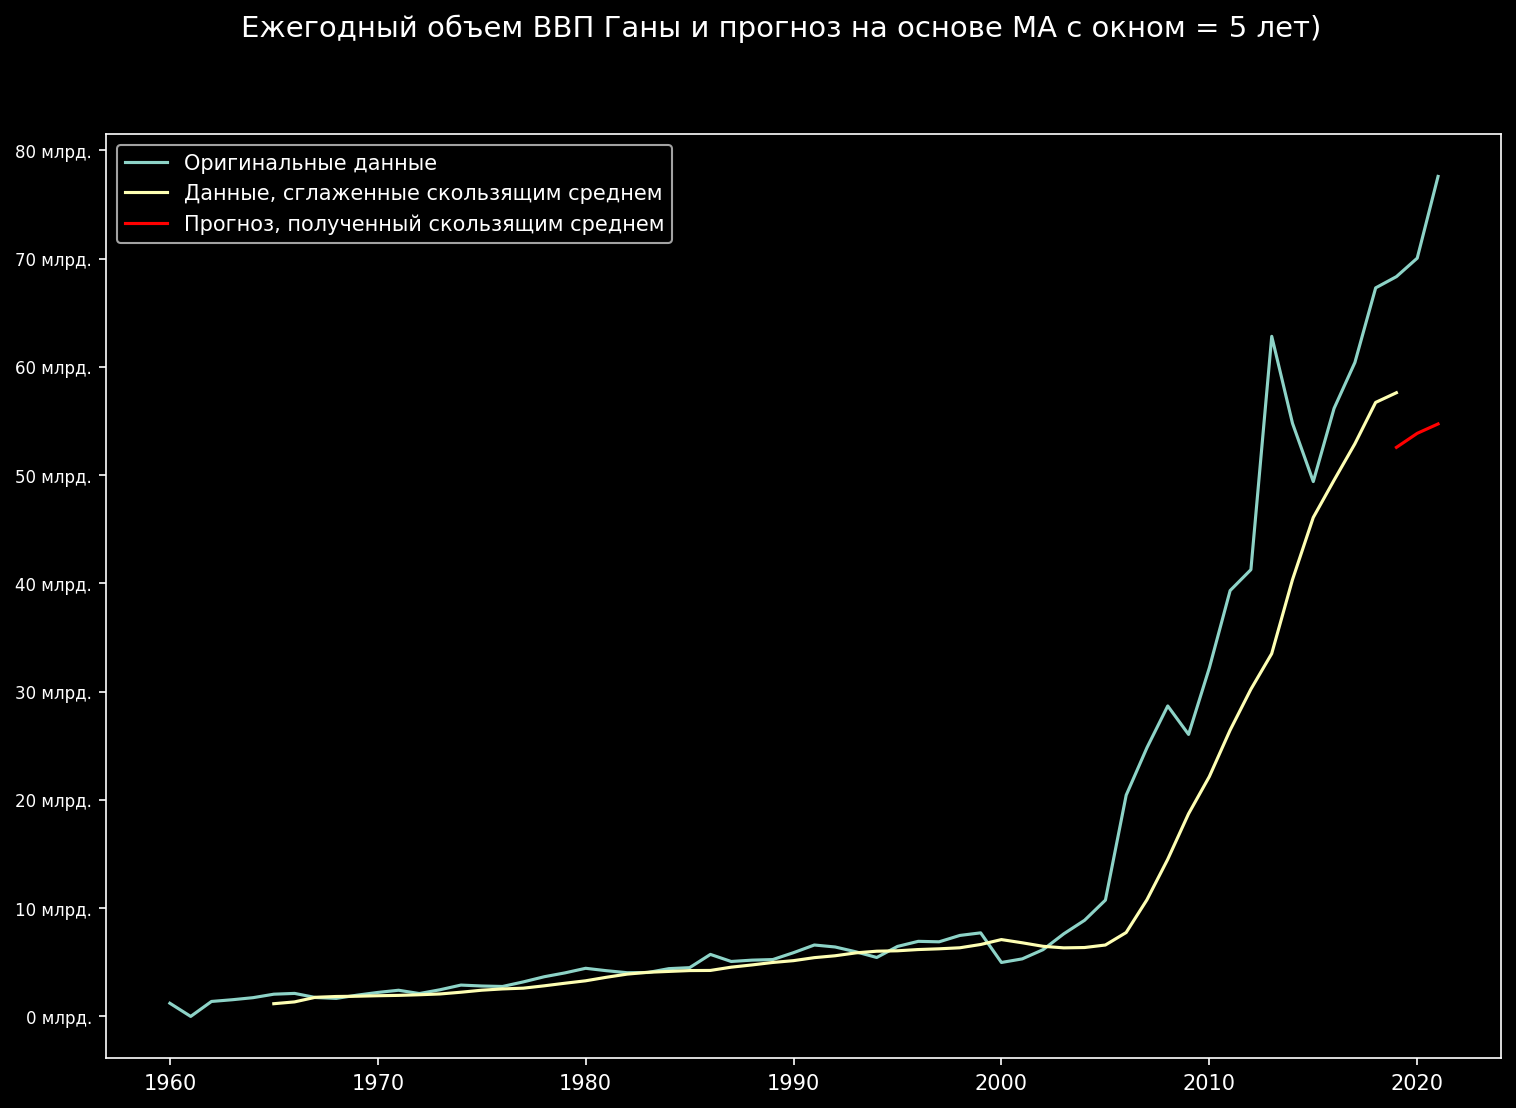

In [10]:
# предсказываем значения

prediction_ma = predict_ma(train_df, 5,3)
# формируем датасет, добавляя необходимые данные
prediction_ma = pd.DataFrame(data = prediction_ma, index=test_df.index, columns = ['gdp'])
# отрисовываем график
plt.figure(figsize=(12, 8), dpi=150)
# график с оригинальными данными
plt.plot(data, label='Оригинальные данные')
# график скользящего с окном 5
plt.plot(train_df.rolling(window = 5).mean(), label='Данные, сглаженные скользящим среднем')
# предсказанные 3 последних значения
plt.plot(prediction_ma, label='Прогноз, полученный скользящим среднем', color = 'red')
plt.legend()
plt.yticks(fontsize = 8, color = 'white')
plt.gca().yaxis.set_major_formatter(formatter)


plt.suptitle('Ежегодный объем ВВП Ганы и прогноз на основе MA с окном = 5 лет)', size=14)
plt.show();


Как и предполагалось, предсказание далеко от реальных значений. Да, мы как минимум предсказываем направление растущего тренда, но учитывая использование среднего в размере окна, при растущем тренде наши предсказанные значения всегда будут ниже, так как среднее не передает информацию о векторе роста шага

## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 4.3</span>

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

<span style="background-color: green; padding: 3px 20px ; color : #fff;">
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA. 
</span>

Параметры p и q выберите по коррелограммам ACF и PACF.

<span style="background-color: green; padding: 3px 20px ; color : #fff;">
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.</span>

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

In [11]:
test_adf = adfuller(train_df.gdp)

print("adf: ", test_adf[0])
print("p-value: ", test_adf[1])
print("Critical values: ", test_adf[4])
if test_adf[0] > test_adf[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885364
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Взяв уровень значимости в 5%, мы четко видим, что значение adf больше 5% критической величины. Это говорит нам о том, что ряд нестационарен и для дальнейшего построения модели прогнозирования, надо сначала привести его к стационарному ряду. Соответственно, модель, которую будем строить, будет модель ARIMA. теперь перейдем к поиску параметров для построения модели

In [12]:
def is_stationary(data: pd.DataFrame) -> (data, bool):
    """Проверка ряда на стационарность

    Args:
        data (pd.DataFrame): датасет

    Returns:
        data, bool: Возвращается диференцированный датасет и статус стационарности
    """
    data = data.diff().dropna()
    test_adf = adfuller(data)
    if test_adf[0] > test_adf[4]["5%"]:
        return data, False
    else:
        return data, True

In [13]:
# Диференцируем ряд, пока не добьемся стационарности
df = train_df.copy()
d = 1
while True:
    df, result = is_stationary(df)
    if not result:
        print(f'При диферинцации ряда {d} порядка, ряд не стационарен')
        d += 1
        pass
    else:
        print(f'При диферинцации ряда {d} порядка, ряд стационарен')
        break


При диферинцации ряда 1 порядка, ряд не стационарен
При диферинцации ряда 2 порядка, ряд не стационарен
При диферинцации ряда 3 порядка, ряд стационарен


Мы добились стационарности ряда на 3-ем порядка. Значит параметр d для ARIMA будет равен 3
Теперь подберем параметры p и q, построив коррелограммы ACF и PACF

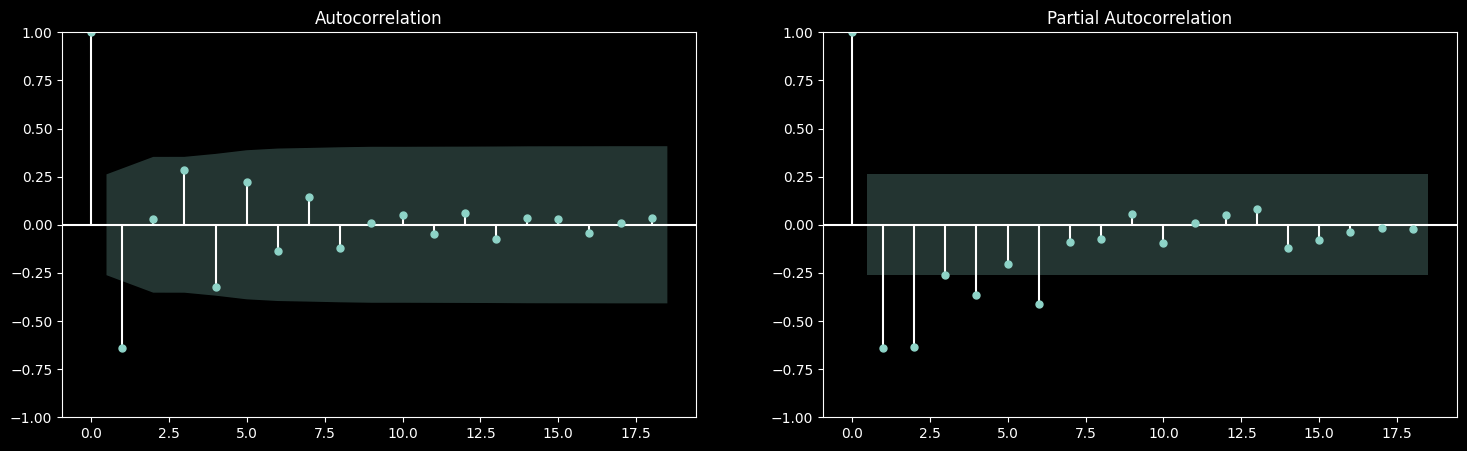

In [14]:
def plot_acf_pacf(series : pd.Series) -> None:
    """Функция строит графики коррелограмм ACF и PACF

    Args:
        series (pd.Series): данные ряда
    """
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1], method="ywm")
    plt.show()

plot_acf_pacf(df)    

По данным коллелограммам я предположу, что q = 1, так как все остальные значения лагов попадают в доверительный диапазон. Для p я выберу 2. Так как 3-ий лаг также в доверительном диапазоне. Опять же, это будут наши отправные точки. Окончательные параметры модели вычислим через рассчет модели при разных параметрах, путем подбора наилучших параметров.


In [15]:
# наши параметры, выявленные в ходе исследования корреллограмм

test_df.index = test_df.index.year

eye_arima = (2,3,1)


Далее я проведу подбор параметров, с использованием библиотеки `pmdarima` и несколько подходов, а именно:
* функционал автоматизированного подбора
* перебор по указанному диапазону значений
* для перебора по диапазону значений, также буду учитывать был ли warning  в момент расчета или нет

In [16]:
def model_arima_creation(data: pd.DataFrame, order: tuple, steps : pd.DataFrame, alpha: float = 0.05, summary : bool = False) -> pd.DataFrame:
    """Строим модель согласна указанным параметрам и возвращаем датасет 
    с предсказанными значениями и доверительным интервалом

    Args:
        data (pd.DataFrame): датасет, на котором будем проводить обучение модели
        order (tuple): параметры для ARIMA, (p,d,q)
        steps (pd.DataFrame): сколько шагов предсказать
        alpha (float): доверительный интервал
        summary (bool, optional): _description_. Выводит summary модели или нет

    Returns:
        pd.DataFrame: Возвращает датасет с предсказанными значениями и нижним и верхним пределом доверительного интервала
    """
    # построение модели
    arima_model = ARIMA(data.gdp.dropna(), order=order)
    arima_model_fit = arima_model.fit()
    if summary:
        print(arima_model_fit.summary())
    
    # Получаем прогноз и доверительные интервалы
    forecast = arima_model_fit.get_forecast(len(steps))
    conf_int = forecast.conf_int(alpha=alpha)
    
    predicted_data = pd.DataFrame({'year': steps.index,
                                   'gdp': forecast.predicted_mean.values,
                                   'lower gdp' : list(conf_int['lower gdp']),
                                   'upper gdp' : list(conf_int['upper gdp']),
                                   })
    predicted_data.set_index('year', inplace=True)
    aic = arima_model_fit.aic

    return predicted_data, aic


def draw_model_graph(plt: plt, axs: np.ndarray, origin_data: pd.DataFrame, interval_data: pd.DataFrame, column: int, row : int, order: tuple, title: str, alpha: int = 0.05) -> None:
    """Функция отвечает за построение графиков скользящего среднего для заданного окна и кол-ва графиков,
    которые располагаются вертикально, один за одним

    Args:
        plt (plt): matplotlib.pyplot обьект
        axs (np.ndarray) : обьект подграфика
        origin_data: pd.DataFrame : тестовый датасет
        interval_data: pd.DataFrame : датасет c нижним и верхним доверительным порогом
        column (int): размещение графика в основной сетке, номер строки
        row (int): размещение графика в основной сетке, номер колонки
        order (tuple): параметры модели, для вывода в title графика
        title (str): информация о способе получения параметров, для вывода в title графика
        alpha (int): информация об уровне alpha, для вывода в title графика
    """

    axs[column,row].plot(origin_data.gdp,
            color='red',
            linewidth=3,
            label='Оригинальный ряд')
    
    axs[column,row].fill_between(interval_data.index,
                     interval_data['lower gdp'],
                     interval_data['upper gdp'],
                     color='none',
                     hatch='//////',
                     edgecolor='b')
    axs[column,row].legend()
    axs[column,row].set_title(f"Прогноз ARIMA ({(1-alpha)*100}% доверительный интервал \n параметры модели p:{order[0]}, d:{order[1]}, q:{order[2]} \n {title} ", size=6, color = 'black')
    
    num_xticklabels = len(origin_data.index)
    xticks_values = np.linspace(origin_data.index.min(), origin_data.index.max(), num=num_xticklabels).astype(int)  # Создаем равномерно распределенные значения
    axs[column,row].set_xticks(xticks_values)
    axs[column,row].set_xticklabels(axs[column,row].get_xticklabels(), color = 'darkred', size = 5)
    axs[column,row].set_yticklabels(axs[column,row].get_yticklabels(), fontsize = 5, color = 'black')
    axs[column,row].yaxis.set_major_formatter(formatter)
    


In [17]:
# используем auto_arima, которая пытается автоматом подобрать лучшие параметры, избегая перебора всех параметров

smodel = pm.auto_arima(
    train_df,
    start_p=4,
    d=3,
    start_q=4,
    max_p=8,
    max_q=8,
    test="adf",
    error_action="ignore",
    trace=False
)
auto_arima_1 = smodel.get_params()['order']
auto_arima_1

(6, 3, 4)

Что интересно, данная функция эвристическая и зависит от переданных в нее параметров. Если обратите внимания, я сменил start_p и start_q и получил отличные друг от друга расчетные данные по параметрам.
Для построения графиков, буду использовать оба параметра

In [18]:
smodel = pm.auto_arima(
    train_df,
    start_p=0,
    d=3,
    start_q=0,
    max_p=8,
    max_q=8,
    test="adf",
    error_action="ignore",
    trace=False
)
auto_arima_2 = smodel.get_params()['order']
auto_arima_2

(2, 3, 1)

Теперь я сделаю перебор в диапазоне p и q от 0 до 8-ми, при константе d = 3
Также, я заметил, что при определенных сочетаних параметров, появляется сообщение о некорекности данных для расчета параметров, и функция немного изменяет данные, чтобы закончить расчет.
Поэтому я добавил Handler для warning-а, и к расчетным данным также добавляю флаг, была ошибка или нет в процесса подбора

In [19]:
def arima_warning_handler(message, category, filename, lineno, file=None, line=None):
    global error
    error = 'e'

# Зарегистрировать функцию-обработчик для предупреждений
warnings.showwarning = arima_warning_handler

# Задайте диапазон значений параметров p и q
p_values = range(1, 8)  # Пример диапазона от 0 до 4 для p
q_values = range(1, 8)  # Пример диапазона от 0 до 4 для q
d_values = [3]

# Создайте комбинации параметров p и q
pq_combinations = list(itertools.product(p_values, q_values, d_values))

# Пройдитесь по всем комбинациям и обучите модели ARIMA
aic_results = []
for p, q, d in pq_combinations:
    error = 'n'
    model = pm.ARIMA(order=(p, d, q))  
    model.fit(train_df)  # Замените your_time_series_data на ваши данные
    aic_results.append((p, q, d, (aic:=model.aic()), error))

best_p, best_q, best_d, best_aic, error = min(aic_results, key=lambda x: x[3])

In [20]:
# Узнаем лучший результат для записей без ошибок
best_aic_no_errors = list(filter(lambda x: x[4] == 'n', aic_results))
best_p, best_q, best_d, best_aic, error = min(best_aic_no_errors, key=lambda x: x[3])
print(f'Лучшая модель: ARIMA({best_p}, {best_d}, {best_q}) - AIC: {best_aic} {error}')
manual_arima_wo_error = (best_p,best_d, best_q)

Лучшая модель: ARIMA(2, 3, 1) - AIC: 2666.240670466051 n


In [21]:
# Узнаем лучший результат для всех записей 
best_p, best_q, best_d, best_aic, error = min(aic_results, key=lambda x: x[3])
print(f'Лучшая модель: ARIMA({best_p}, {best_d}, {best_q}) - AIC: {best_aic} {error}')
manual_arima_w_error = (best_p,best_d, best_q)

Лучшая модель: ARIMA(7, 3, 2) - AIC: 2629.610839935591 e


Как видим, лучший результат с перебором мы получили для расчетной модели, в процессе которой произошли ошибки

Итак, у нас есть параметры:
* полученные на глаз, при анализе коллелограмм
* 2 набора параметров, подобранные автоматическим способом
* 2 набора параметров, полученные в результате перебора с мониторингом ошибок

Теперь можем построить графики, с указанием доверительного интервала в 95%

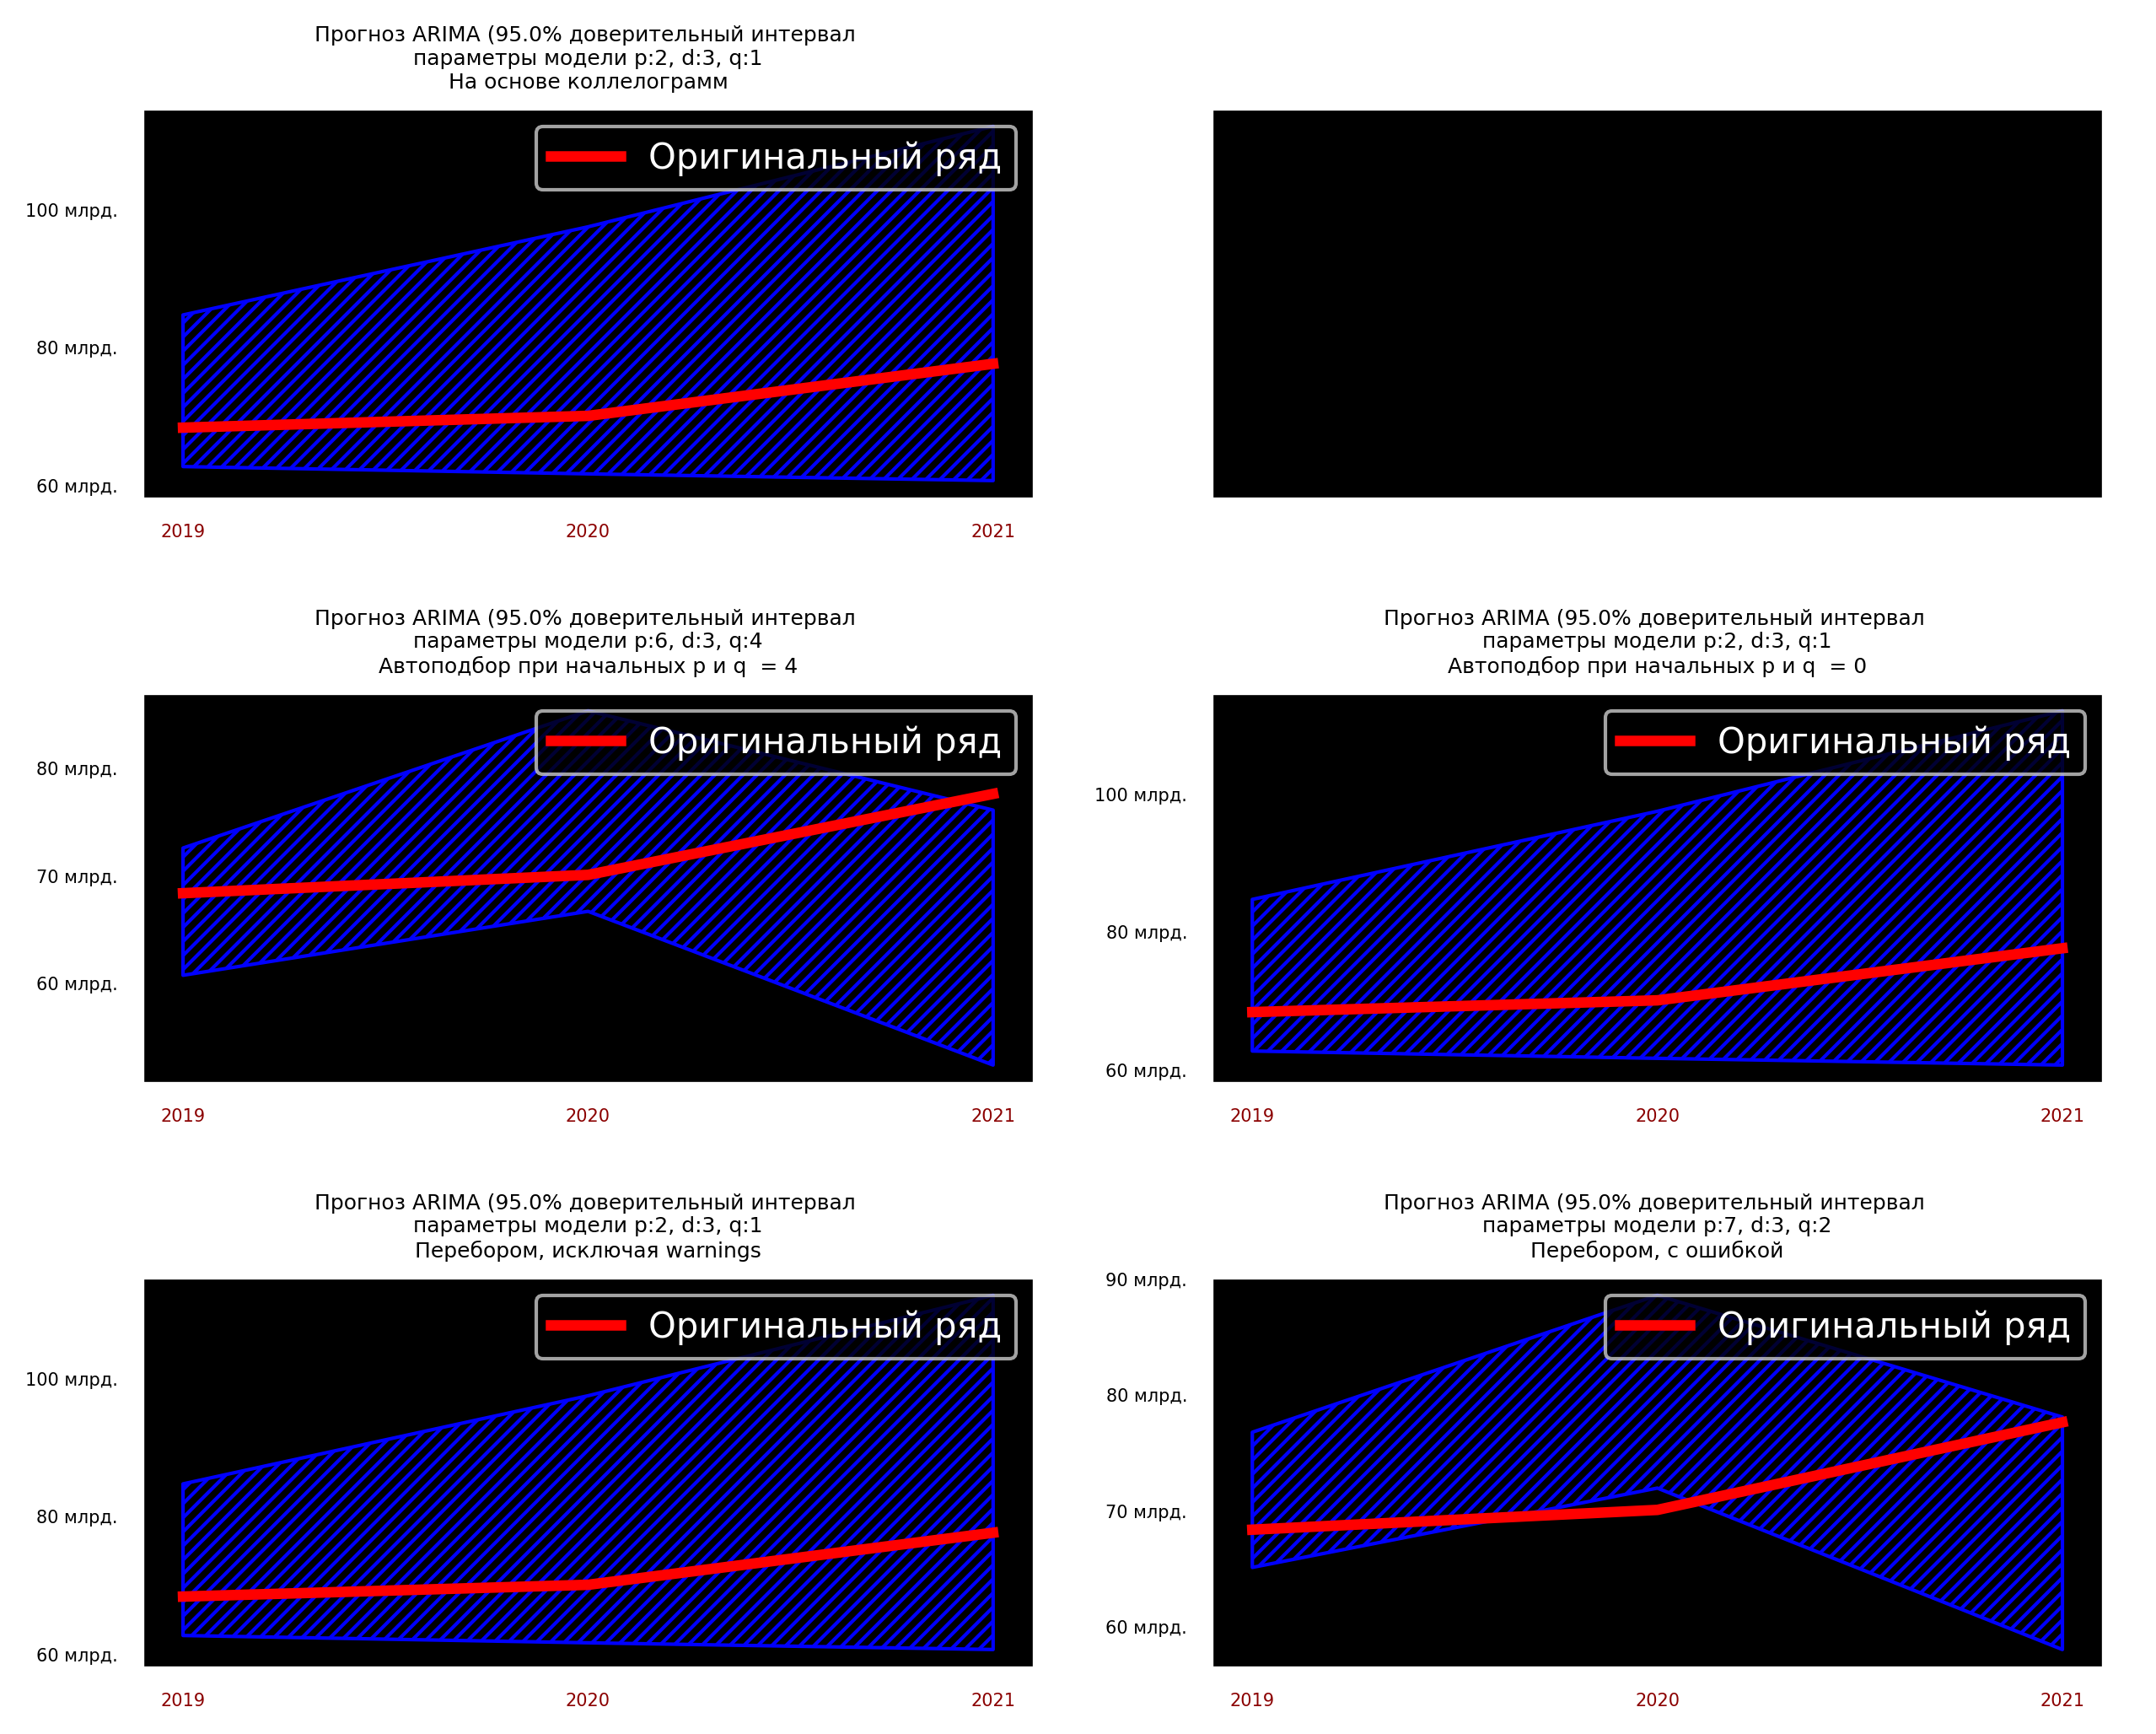

In [22]:
# scale для вертикального размера обьекта plt
y_size = 2
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 4 * y_size), facecolor='white', dpi = 300)
plt.subplots_adjust(hspace=0.5)

results_4_unit = {}

order = eye_arima
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs, test_df, prediction_arima, 0,0, order,'На основе коллелограмм')
results_4_unit[f"unit4_eye_arima"] = aic

order = auto_arima_1
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 1,0, order, 'Автоподбор при начальных p и q  = 4')
results_4_unit[f"unit4_auto_arima_1"] = aic

order = auto_arima_2
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 1,1, order, 'Автоподбор при начальных p и q  = 0')
results_4_unit[f"unit4_auto_arima_2"] = aic

order = manual_arima_wo_error
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 2,0, order, 'Перебором, исключая warnings')
results_4_unit[f"unit4_manual_arima_wo_error"] = aic

order = manual_arima_w_error
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 2,1, order, 'Перебором, с ошибкой')
results_4_unit[f"unit4_manual_arima_w_error"] = aic

plt.show()

Как видно из графиков, у нас 3 практически идентичных графика, который в достаточной мере повторяют тренд и находятся полностью в доверительном интервале. Да, есть достаточно большое смещение, но если брать, что мы должны попасть в 95% интервал - это условие выполняется.

Данной картины нам удалось добиться, используя параметры полученные:
* при визуальном анализе коллелограмм
* автоматический подбор параметров, при начальных p и q равных 0
* путем перебора, без warnings

Параметры полученные:
* автоматически, при начальных p и q равных 4
* перебором, игнорируя warnings

Дали худшие результаты, линия тренда несоблюдена, что указывает, что на 4 и далее шагах предсказания, скорее всего предсказание сильно уйдет далеко от реального
Также они оба выходят за пределы доверительного интервала.

Из чего можем сделать вывод, подбор параметров, это очень важны1 момент,
и нельзя полагаться на 1 способ получения параметров.

Также надо обращать внимания на начальные параметры p и q, используя автоматический эвристический способ поиска лучших параметров
А в случае перебора значений, возможно также есть смысл обращать на сообщения об ошибках в процессе поиска.




## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 6.1</span>

Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода DataFrame.asfreq(), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц.

Все алиасы для параметров частоты доступны [ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

In [23]:
# Проверяем на возможно пропущенные года в последовательности
print(f"Количество пропущенных годов в последовательности : {data.asfreq(freq='AS').isna().sum().values[0]}")

Количество пропущенных годов в последовательности : 0


## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 6.2</span>
Проверьте данные на наличие пропущенных значений

In [24]:
# Проверяем на возможно пропущенные значения
print(f"Количество пропусков: {data.gdp.isna().sum()}")

Количество пропусков: 0


## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 6.3</span>

Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN

In [25]:
# Ищем нулевые и заполняем NaN вместо 0
data.gdp = data.gdp.mask(data.gdp == 0, float('nan'))
data.gdp.isna().sum()

1

## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 6.4</span>

Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate()

In [26]:
data.gdp = data.gdp.interpolate(method='linear')
data.head(3)

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09


In [27]:
# Отложим последние три года из датасета, как тестовую выборку для оценки результатов предсказания.
test_df = data.iloc[-3:]
train_df = data.iloc[:-3]

# явно укажем частоту временного ряда, как год, чтобы избежать warning при обучению модели и дать модели, 
# какой у нас используется период точно
train_df.index = pd.to_datetime(train_df.index,format='%Y-%m-%d').to_period(freq='Y')


test_df

,gdp
year,
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 6.5</span>

Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [28]:
# Воспользуемся уже реализованной выше функцией для определения стационарности ряда
# Диференцируем ряд, пока не добьемся стационарности
df = train_df.copy()
d = 1
while True:
    df, result = is_stationary(df)
    if not result:
        print(f'При диферинцации ряда {d} порядка, ряд не стационарен')
        d += 1
        pass
    else:
        print(f'При диферинцации ряда {d} порядка, ряд стационарен')
        break

При диферинцации ряда 1 порядка, ряд не стационарен
При диферинцации ряда 2 порядка, ряд не стационарен
При диферинцации ряда 3 порядка, ряд стационарен


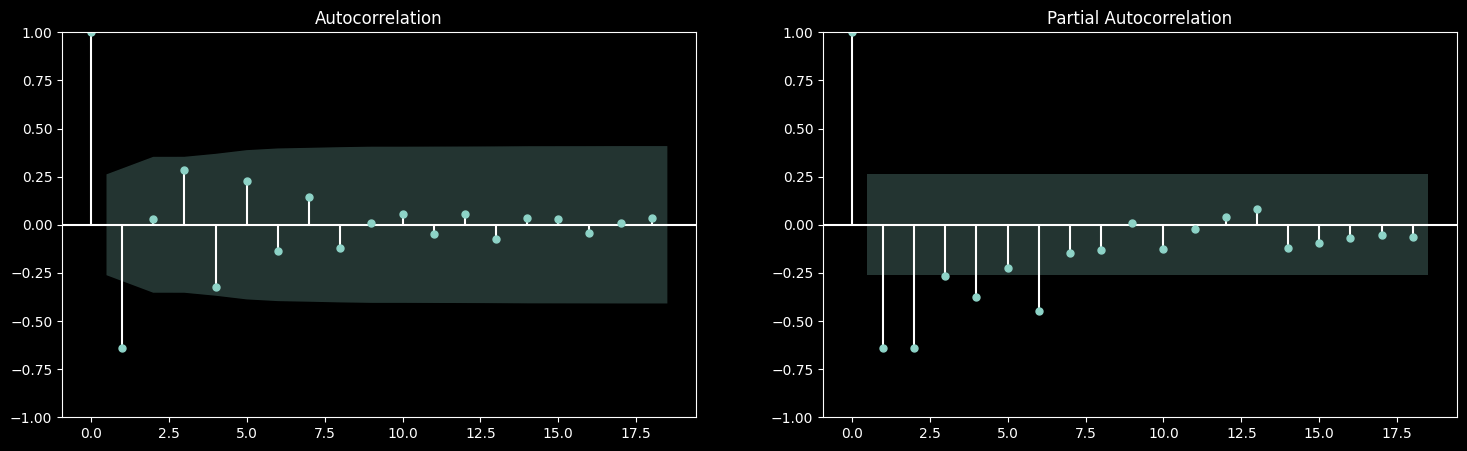

In [29]:
plot_acf_pacf(df)

После применения интерполяции, графики почти не изменились, что в принципе ожидаемо, так как изменения проведенные с помощью интерполяции затронули лишь один элемент, никак не повлияв на сезонность, цикличность и тренд

Сделаем подбор параметров таким же образом как и для на первом шаге (на основе коллелограмм, автоподбор и перебором)


In [30]:
# наши параметры, выявленные в ходе исследования корреллограмм

test_df.index = test_df.index.year

eye_arima = (2,3,1)

In [31]:
# используем auto_arima, которая пытается автоматом подобрать лучшие параметры, избегая перебора всех параметров

smodel = pm.auto_arima(
    train_df,
    start_p=4,
    d=3,
    start_q=4,
    max_p=8,
    max_q=8,
    test="adf",
    error_action="ignore",
    trace=False
)
auto_arima_1 = smodel.get_params()['order']
auto_arima_1

(6, 3, 4)

In [32]:
smodel = pm.auto_arima(
    train_df,
    start_p=0,
    d=3,
    start_q=0,
    max_p=8,
    max_q=8,
    test="adf",
    error_action="ignore",
    trace=False
)
auto_arima_2 = smodel.get_params()['order']
auto_arima_2

(2, 3, 1)

In [33]:
# Задайте диапазон значений параметров p и q
p_values = range(1, 8)  # Пример диапазона от 0 до 4 для p
q_values = range(1, 8)  # Пример диапазона от 0 до 4 для q
d_values = [3]

# Создайте комбинации параметров p и q
pq_combinations = list(itertools.product(p_values, q_values, d_values))

# Пройдитесь по всем комбинациям и обучите модели ARIMA
aic_results = []
for p, q, d in pq_combinations:
    error = 'n'
    model = pm.ARIMA(order=(p, d, q))  
    model.fit(train_df)  # Замените your_time_series_data на ваши данные
    aic_results.append((p, q, d, (aic:=model.aic()), error))

best_p, best_q, best_d, best_aic, error = min(aic_results, key=lambda x: x[3])

In [34]:
# Узнаем лучший результат для записей без ошибок
best_aic_no_errors = list(filter(lambda x: x[4] == 'n', aic_results))
best_p, best_q, best_d, best_aic, error = min(best_aic_no_errors, key=lambda x: x[3])
print(f'Лучшая модель: ARIMA({best_p}, {best_d}, {best_q}) - AIC: {best_aic} {error}')
manual_arima_wo_error = (best_p,best_d, best_q)

Лучшая модель: ARIMA(4, 3, 3) - AIC: 2651.115170304902 n


In [35]:
# Узнаем лучший результат для всех записей 
best_p, best_q, best_d, best_aic, error = min(aic_results, key=lambda x: x[3])
print(f'Лучшая модель: ARIMA({best_p}, {best_d}, {best_q}) - AIC: {best_aic} {error}')
manual_arima_w_error = (best_p,best_d, best_q)

Лучшая модель: ARIMA(7, 3, 2) - AIC: 2628.479053233784 e


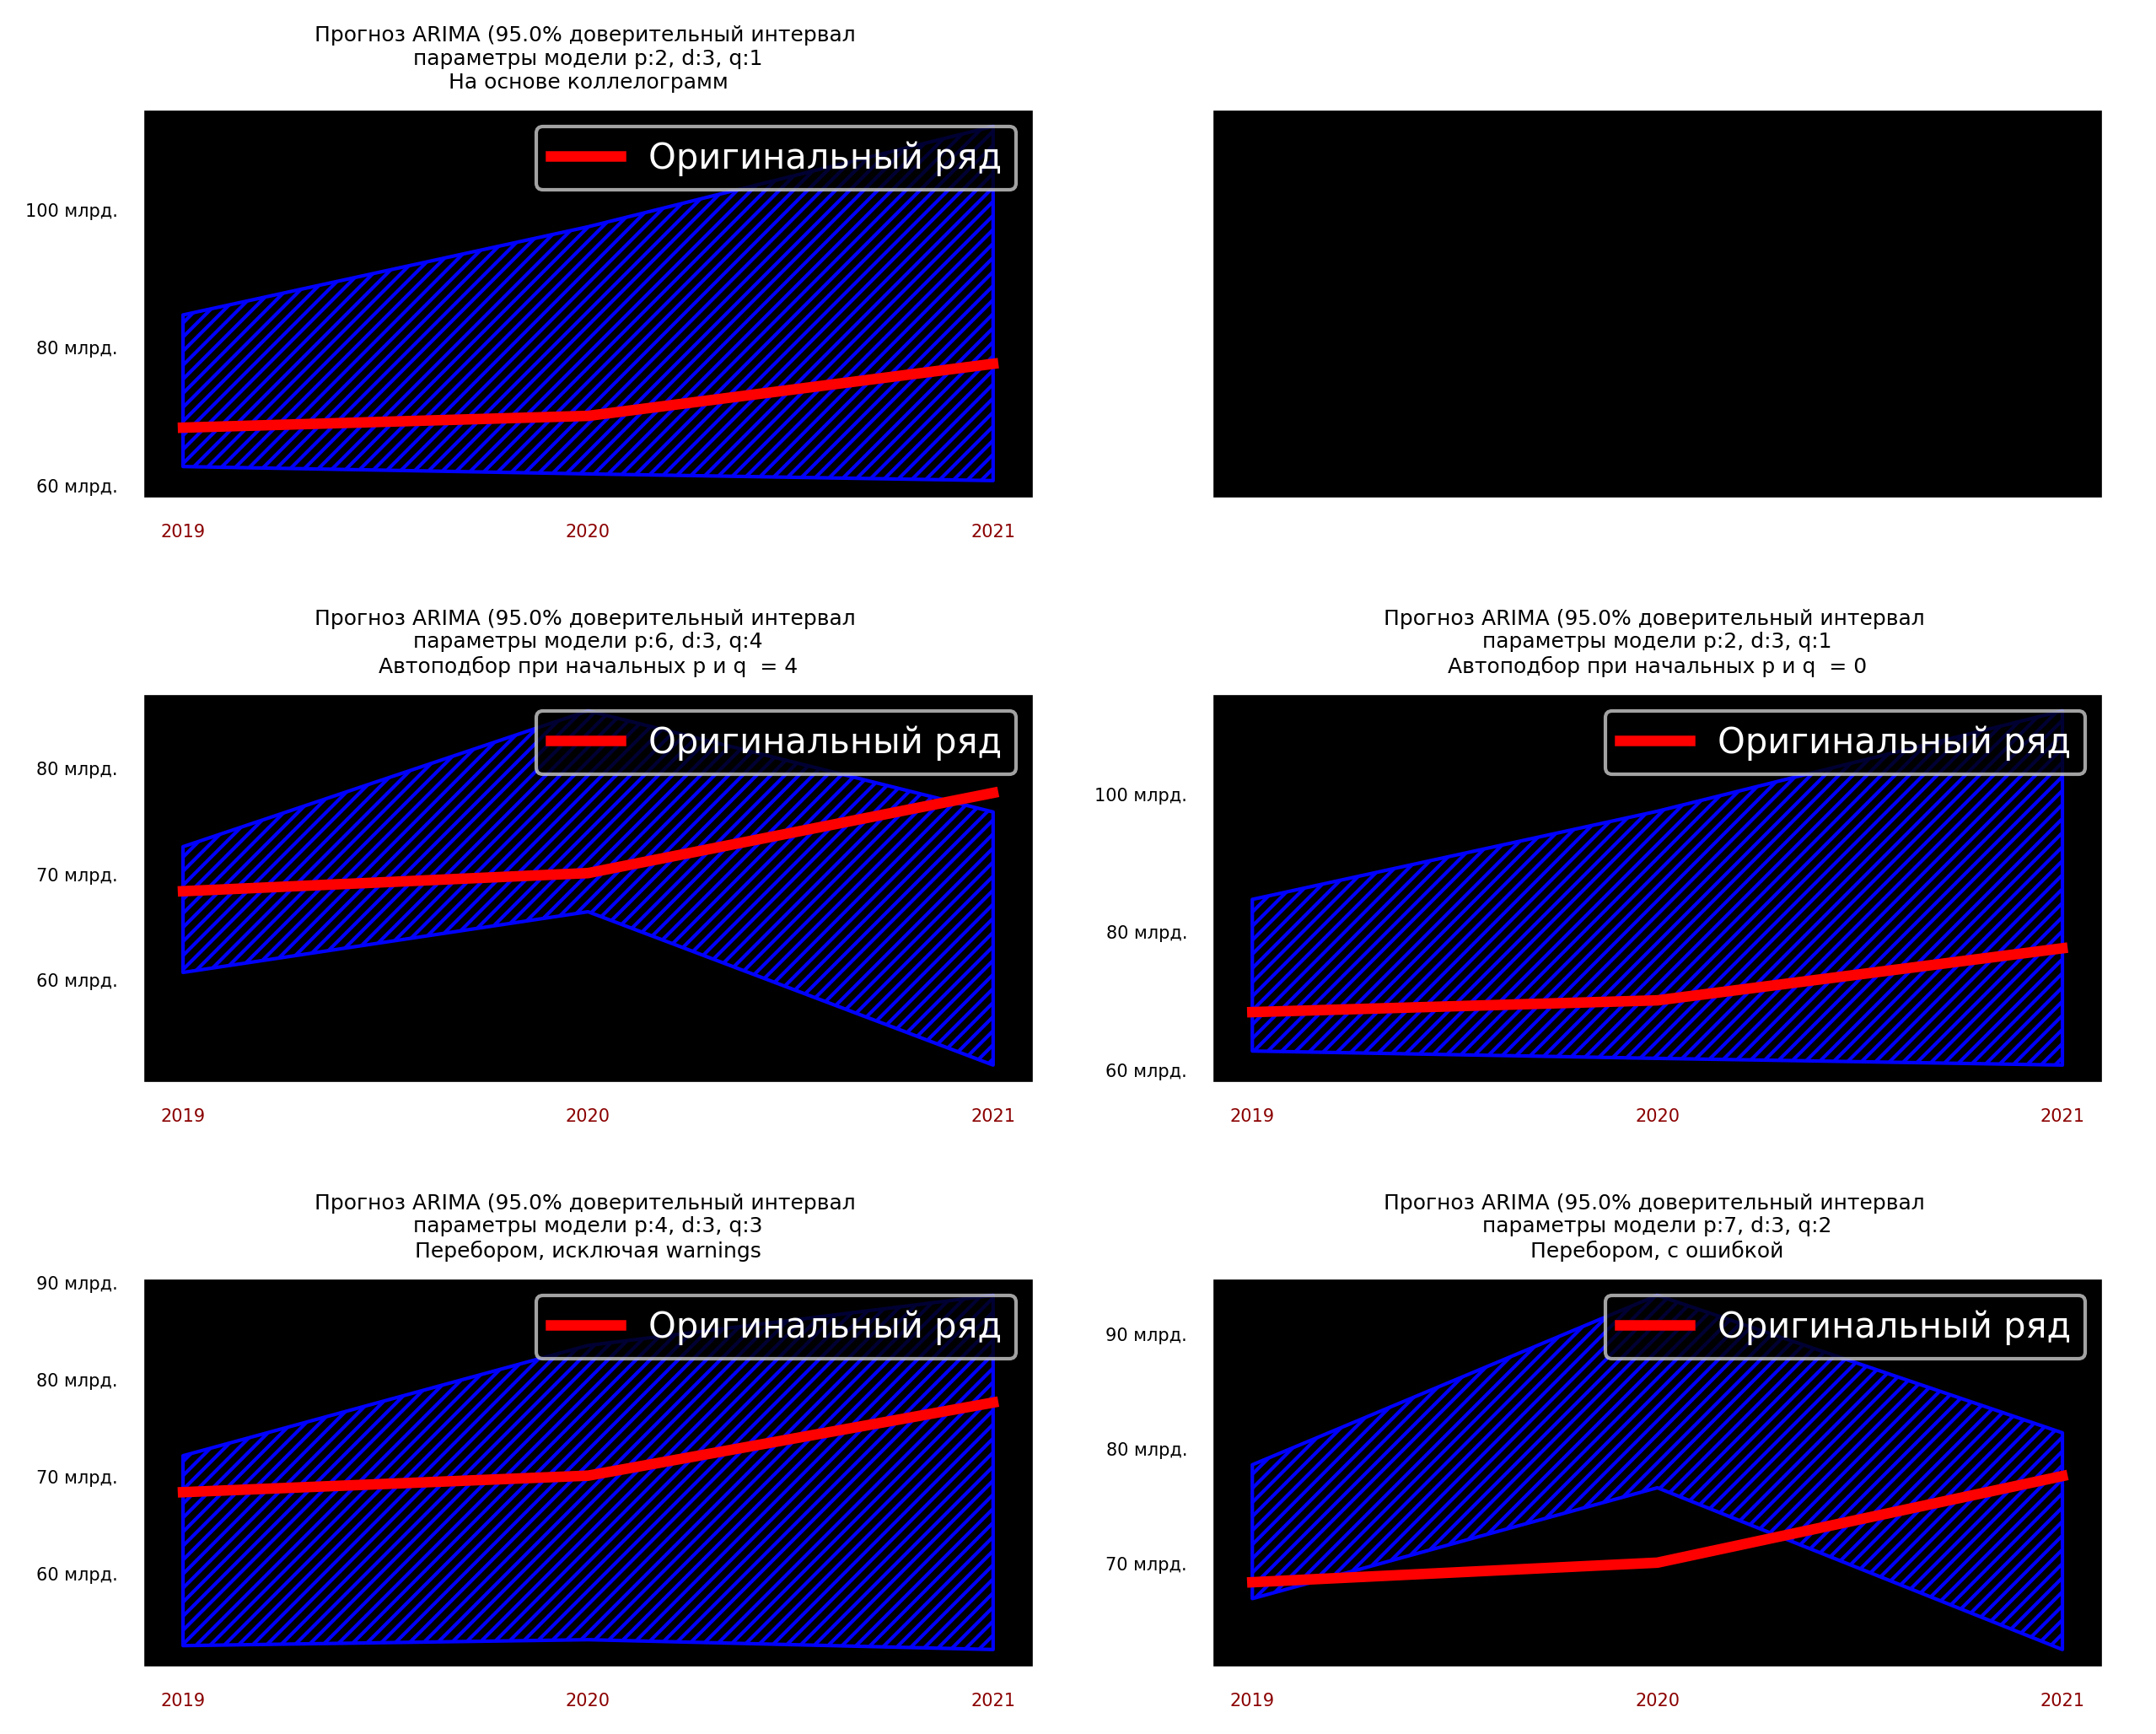

In [36]:
# scale для вертикального размера обьекта plt
y_size = 2
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 4 * y_size), facecolor='white', dpi = 300)
plt.subplots_adjust(hspace=0.5)

order = eye_arima
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs, test_df, prediction_arima, 0,0, order,'На основе коллелограмм')
results_4_unit[f"unit6_eye_arima"] = aic

order = auto_arima_1
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 1,0, order, 'Автоподбор при начальных p и q  = 4')
results_4_unit[f"unit6_auto_arima_1"] = aic

order = auto_arima_2
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 1,1, order, 'Автоподбор при начальных p и q  = 0')
results_4_unit[f"unit6_auto_arima_2"] = aic

order = manual_arima_wo_error
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 2,0, order, 'Перебором, исключая warnings')
results_4_unit[f"unit6_manual_arima_wo_error"] = aic

order = manual_arima_w_error
prediction_arima, aic = model_arima_creation(train_df, order, test_df,summary=False)
draw_model_graph(plt, axs,test_df, prediction_arima, 2,1, order, 'Перебором, с ошибкой')
results_4_unit[f"unit6_manual_arima_w_error"] = aic

plt.show()

## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 6.6</span>

Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.


In [37]:
# давайте посмотрим на все значения AIC, что были получены в процессе построения моделей
results_df = pd.DataFrame(data = results_4_unit.values(), index = results_4_unit.keys(), columns=['AIC'])
results_df.sort_values('AIC')

,AIC
unit6_auto_arima_1,2624.993558
unit4_auto_arima_1,2626.066537
unit6_manual_arima_w_error,2627.991976
unit4_manual_arima_w_error,2628.939566
unit6_manual_arima_wo_error,2649.319600
unit6_eye_arima,2659.226105
unit6_auto_arima_2,2659.226105
unit4_eye_arima,2659.230811
unit4_auto_arima_2,2659.230811
unit4_manual_arima_wo_error,2659.230811


In [38]:
# Посмотрим на изменение AIC
# Приведем к новому виду индексы, чтобы отсортировать попарно измерения AIC приодинаковых параметрах при перовм и втором шаге,
# т.е. до интерполяции и после
results_df.index = results_df.index.str[6:] + '_' + results_df.index.str[:5]
results_df = results_df.sort_index().reset_index()
results_df
results_df['difference'] = results_df.AIC.diff().where(results_df.index % 2 != 0).fillna(0)
results_df

,index,AIC,difference
0,auto_arima_1_unit4,2626.066537,0.000000
1,auto_arima_1_unit6,2624.993558,-1.072979
2,auto_arima_2_unit4,2659.230811,0.000000
3,auto_arima_2_unit6,2659.226105,-0.004706
4,eye_arima_unit4,2659.230811,0.000000
5,eye_arima_unit6,2659.226105,-0.004706
6,manual_arima_w_error_unit4,2628.939566,0.000000
7,manual_arima_w_error_unit6,2627.991976,-0.947590
8,manual_arima_wo_error_unit4,2659.230811,0.000000
9,manual_arima_wo_error_unit6,2649.319600,-9.911212


Соберем информацию вместе

Как видно из последней таблицы, после интерполяции AIC снизился при всех параметрах. Что говорит нам, нулевые или пропущенные значения, в той или иной мере влияют в худшую сторону без прмиенения интерполяции

Если посмотрим на первый датасет, то наименьший AIC был получен при параметрах (6,3,4) с чем я в корне не согласен, так как если посмотрим на график, мы выпадаем из тренда и из доверительного интервала

Второе место с наименьшим AIC также принадлежит модели, неугадавшей тренд и непопавшей в доверительный интервал полностью

Отсюда я могу сделать вывод, если я правильно понял идею всего выше мною произведенного в предсказании временных рядов, то только на параметр AIC полагаться нельзя, надо делать комплексную проверку предсказания.


## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 9.1</span>

Посчитайте волатильность для вашего временного ряда.

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$


In [39]:
data.index = data.index.year
data['gdp_v'] = data.gdp.pct_change(1).mul(100).abs()
data.head()

,gdp,gdp_v
year,,
1960,1.217087e+09,NaN
1961,1.299720e+09,6.789413
1962,1.382353e+09,6.357759
1963,1.540616e+09,11.448835
1964,1.731092e+09,12.363636


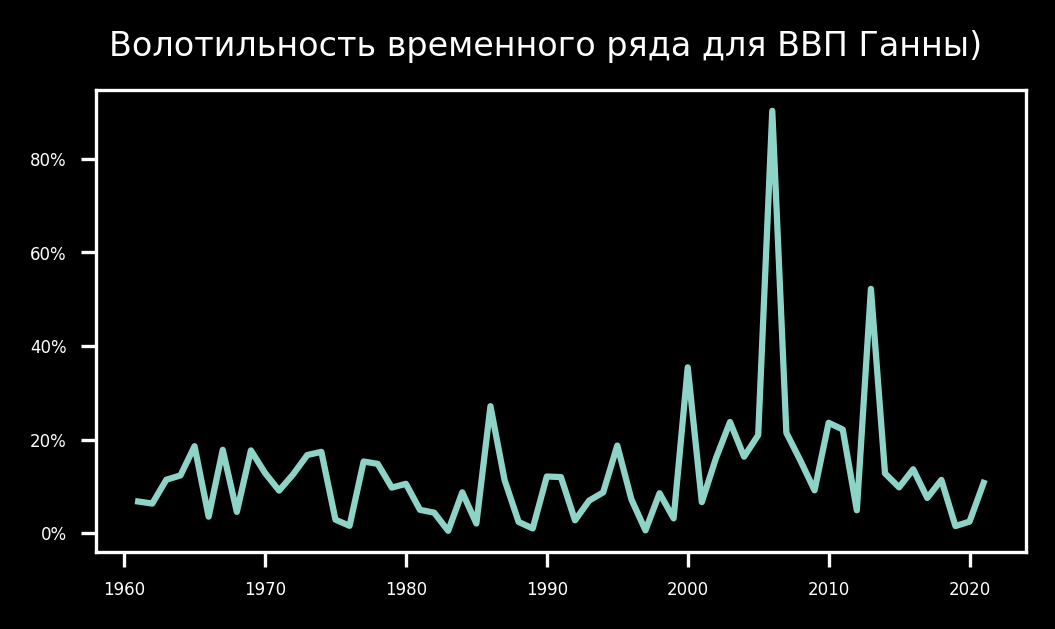

In [40]:
plt.figure(figsize=(4, 2), dpi=300)
# график с оригинальными данными
plt.plot(data.gdp_v)
plt.yticks(fontsize = 4, color = 'white')
plt.xticks(fontsize = 4, color = 'white')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%"))


plt.suptitle('Волотильность временного ряда для ВВП Ганны)', size=8)
plt.show();

## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 9.2</span>

Используйте GARCH-модель для предсказания волатильности

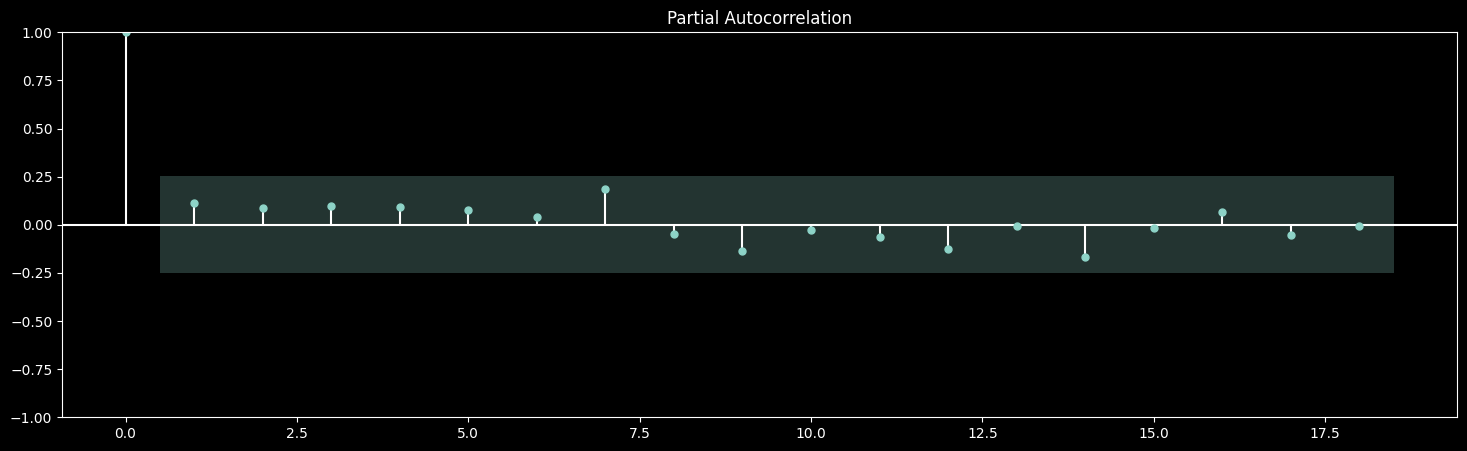

In [41]:
# Отложим последние три года из датасета, как тестовую выборку для оценки результатов предсказания.
test_df = data.iloc[-3:]
train_df = data.iloc[:-3]

sgt.plot_pacf(data.gdp_v[1:], method="ywm")
plt.show()

In [42]:
# Воспользуемся уже реализованной выше функцией для определения стационарности ряда
# Диференцируем ряд, пока не добьемся стационарности
df = train_df.gdp_v[1:].copy()
d = 1
while True:
    df, result = is_stationary(df)
    if not result:
        print(f'При диферинцации ряда {d} порядка, ряд не стационарен')
        d += 1
        pass
    else:
        print(f'При диферинцации ряда {d} порядка, ряд стационарен')
        break

При диферинцации ряда 1 порядка, ряд стационарен


In [43]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data.gdp_v.loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "gdp_v"] = train_df.gdp_v.dropna()
garch_df.head()

,gdp_v
year,
1960,NaN
1961,6.789413
1962,6.357759
1963,11.448835
1964,12.363636


При изучении коллелограммы я вижу, что p = 1
Относительно q, я точно не понял, вычислять ли его похожим способом, как мы делали для этого, или же рассчитывать перебором

В данном случае возьму p=1, q=1

In [44]:
# Это я отсавил на память.
# Если индексы не типа datetime, то нельзя использовать параметр last_obs и предсказание 
# сможете получить только для посленей записи + колво шагов horizon
# garch_df.index = pd.to_datetime(garch_df.index, format='%Y')
# model = arch_model(garch_df.gdp_v.dropna(), vol='GARCH', p=1, q=1)
# model_results = model.fit(last_obs=garch_df.index[-2])
# model_results.forecast( reindex=False).variance

In [45]:
model = arch_model(train_df.gdp_v.dropna(), vol='GARCH', p=1, q=1)
model_results = model.fit(10)


Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [46]:
forecast_serie = model_results.forecast(horizon=3, reindex=False).variance.iloc[0]
test_df['vol_prediction'] = forecast_serie.values
test_df

,gdp,gdp_v,vol_prediction
year,,,
2019,6.833754e+10,1.542746,284.875990
2020,7.004320e+10,2.495937,288.546011
2021,7.759428e+10,10.780603,292.216032


In [47]:
# рассчитаем mse
mean_squared_error(
    test_df.gdp_v.abs(), test_df.vol_prediction
)

80436.09085933738

И как обычно, переберем диапазон для p и q, рассчитаем mse, для построенных моделей, и попробуем выбрать для окончательной модели параметры, с минимальным mse

In [48]:
mse = {}

for p,q in product(range(1,11), range(1,11)):
    model = arch_model(train_df.gdp_v.dropna(), vol='GARCH', p=p, q=q)
    model_results = model.fit(disp='off')
    forecast_serie = model_results.forecast(horizon=3, reindex=False).variance.iloc[0]
    test_df['vol_prediction'] = forecast_serie.values
    mse[(p,q)] = mean_squared_error(
            test_df.gdp_v.abs(), test_df.vol_prediction
        )

В итоге мы получили параметры при которых mse минимально. Это p = 2, q = 9

In [49]:
min_key = min(mse, key=mse.get)
min_key

(2, 9)

Построим модель на полученных параметрах

In [50]:
model = arch_model(train_df.gdp_v.dropna(), vol='GARCH', p=2, q=9)
model_results = model.fit(disp='off')
forecast_serie = model_results.forecast(horizon=3, reindex=False).variance.iloc[0]
test_df['vol_prediction'] = forecast_serie.values
test_df

,gdp,gdp_v,vol_prediction
year,,,
2019,6.833754e+10,1.542746,264.726575
2020,7.004320e+10,2.495937,264.726575
2021,7.759428e+10,10.780603,264.726575


## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 9.3</span>

Используйте линейную регрессию для получения прогноза

In [51]:
X_train = pd.DataFrame(range(data.gdp_v.shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data.gdp_v.shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df.gdp_v.fillna(0)
y_test = test_df.gdp_v.fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

In [52]:
test_df['lr_prediction'] = lr_predict
test_df

,gdp,gdp_v,vol_prediction,lr_prediction
year,,,,
2019,6.833754e+10,1.542746,264.726575,20.060321
2020,7.004320e+10,2.495937,264.726575,20.287960
2021,7.759428e+10,10.780603,264.726575,20.515600


## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 9.4</span>

Визуализируйте полученное предсказание вместе с фактическим значением

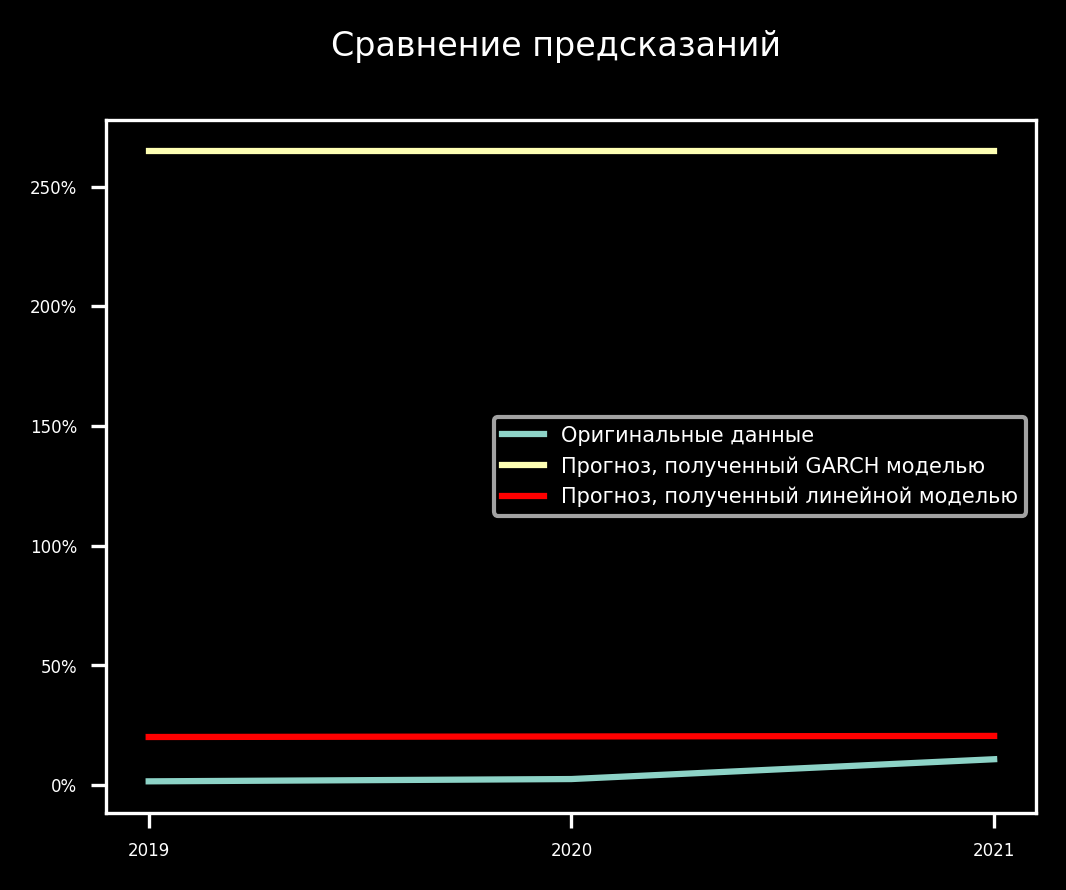

In [53]:
plt.figure(figsize=(4, 3), dpi=300)
# график с оригинальными данными
plt.plot(test_df.gdp_v, label='Оригинальные данные')
# график скользящего с окном 5
plt.plot(test_df.vol_prediction, label='Прогноз, полученный GARCH моделью')
# предсказанные 3 последних значения
plt.plot(test_df.lr_prediction, label='Прогноз, полученный линейной моделью', color = 'red')
plt.legend(fontsize = 5)
plt.yticks(fontsize = 4, color = 'white')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.0f}%"))

num_xticklabels = len(test_df.index)
xticks_values = np.linspace(test_df.index.min(), test_df.index.max(), num=num_xticklabels).astype(int)  # Создаем равномерно распределенные значения
plt.xticks(xticks_values, fontsize = 4, color = 'white')


plt.suptitle('Сравнение предсказаний', size=8)
plt.show();

## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 9.5</span>

Сравните результаты и сделайте выводы.

Как видно из вышеидущего графика, предсказание поведения волотильности модель GARCH не смогла уловить от слова вообще

Может показаться, что линейная модель справилась лучше, ввиду того что ее значения находятся, как минимум, по сравнению с GARCH, намного "ближе" к настоящим значениям. Однако эт отоже ошибочно. потому как наша линейная модель строится на одном ряде с данными, в виду чего линейная модель не улавливает никаких колебаний, а грубо говоря применяет среднее для всего ряда.

Так что обе модели, не справились с поставленной задачей

## <span style="background-color: #4473fd; padding: 3px 20px ; color : #fff; width : 100px">Задание 9.6</span>

Почему результат модели GARCH получился именно таким?

Скорее всего 2 проблемы:
* малое количество данных
* резкие скачки

Из-за этого, модели тяжело точно уловить дисперсию данных